# Enrich data with Thumbnails

## DO NOT RUN THIS NOTEBOOK 

### Inhalte dieses Notebooks werden nicht für die Modelle verwendet und dieses alleine der anschaulichkeit, dass Bilder als zusätzliche Daten die Vorhersage nicht verbessern würden. Benötigte Preprocessing SChritte sind demnach nicht länger Aktive und auskommentieren würde den bisherigen Output überschreiben. Dieser kann helfen die Funktionen nachzuvollziehen.

Hätte dieses Modell eine ausreichend Performance hätte dieses Modell mit einem weiteren Input und mithilfe der Keras Functional API und der concatinate-Layer zum bisherigen Deep Learning Modell hinzugefügt.

# Imports

In [1]:
from typing import Iterator, List, Union, Tuple
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import History

import tensorflow_addons as tfa

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-06-21 17:02:55.487528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/Caskroom/miniconda/base/envs/yputube_2/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Load Data

In [2]:
# Image Data
df = pd.read_csv("../Data/final_dataset_cnn.csv")
df = df.dropna()

# Append .jpg to filename as automatic handeling “has_ext” is deprecated

def append_ext(fn):
    return fn+".jpg"

df["thumbnail_link"]=df["thumbnail_link"].apply(append_ext)
df["test"]= int(5)

df = df [:100]

df


,views,thumbnail_link,test
0,17158579,n1WpP7iowLc.jpg,5
1,1014651,0dBIkQ4Mz1M.jpg,5
3,2095828,d380meD0W0M.jpg,5
4,33523622,2Vv-BfVoq4g.jpg,5
5,1309699,0yIWz1XEeyc.jpg,5
...,...,...,...
121,2682879,F6HTw5DU670.jpg,5
122,2642930,ujyTQNNjjDU.jpg,5
123,260199,1YhtkrC2t0c.jpg,5
124,1504950,lnFaRuWOLN0.jpg,5


## Train - Test - Split

In [5]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df, test_size=0.2, random_state=1)  # train-validation split with validation size of 20%
train, test = train_test_split( train, test_size=0.125, random_state=1 )  # train-test split with test size of 10%

print(f"shape train: {train.shape} \nshape val: {val.shape} \nshape test: {test.shape}")

shape train: (70, 3) 
shape val: (20, 3) 
shape test: (10, 3)


# Prepare Data

In [6]:
# Create keras ImageDataGenerators used for training, validating and testing of your models.

# Create an ImageDataGenerator for training and apply different image augmentations

data_generator = ImageDataGenerator(
    rescale=1.0 / 255, 
    rotation_range=5, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.75, 1),
    shear_range=0.1,
    zoom_range=[0.75, 1],
    horizontal_flip=True,
    validation_split=0.2,
)  

train_generator = data_generator.flow_from_dataframe(
    dataframe=train,
    directory='../Data/thumbnails/',
    x_col="thumbnail_link",  
    y_col="views",  # target
    class_mode="raw",  # for regression tasks
    target_size=(224,224),
    batch_size=50, # increase or decrease to fit your GPU -> reduzieren
    validate_filenames=False,
)

# Create an ImageDataGenerator for validation with no additional augmentations

validation_generator = ImageDataGenerator( rescale=1.0 / 255 )

validation_generator = validation_generator.flow_from_dataframe(
    dataframe=val,
    directory='../Data/thumbnails/',
    x_col="thumbnail_link",
    y_col="views",
    class_mode="raw",
    target_size=(224,224),
    batch_size=50,
    validate_filenames=False,
)

# Create an ImageDataGenerator for testing with no additional augmentations

test_generator = ImageDataGenerator(rescale=1.0 / 255) 

test_generator = test_generator.flow_from_dataframe(
    dataframe=test,
    directory='../Data/thumbnails/',
    x_col="thumbnail_link",
    y_col="views",
    class_mode="raw",
    target_size=(224,224),
    batch_size=50,
    validate_filenames=False,
)

Found 70 non-validated image filenames.
Found 20 non-validated image filenames.
Found 10 non-validated image filenames.


## Visulize Augumentation

Found 2 non-validated image filenames.


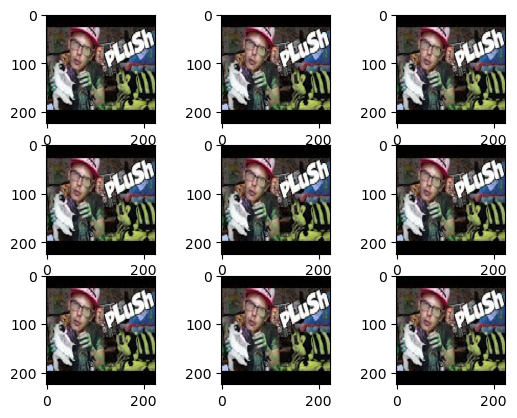

In [9]:

series = df.iloc[1] # choose example image

df_augmentation_visualization = pd.concat([series, series], axis=1).transpose()

iterator_visualizations = data_generator.flow_from_dataframe( # create Image Data Generator with test example
    dataframe=df_augmentation_visualization,
    directory='../Data/thumbnails/',
    x_col="thumbnail_link",  
    y_col="views",  # target
    class_mode="raw",  # for regression tasks
    target_size=(224,224),
    batch_size=128, # increase or decrease to fit your GPU
    validate_filenames=False,
)

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)  # create a 3x3 grid
    batch = next(iterator_visualizations)  # get the next image of the generator (always the same image)
    img = batch[0]
    img = img[0, :, :, :]  # remove one dimension for plotting without issues
    plt.imshow(img)

plt.show()

## Own Convolutional Neural Networks

Followed these examples:

https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

In [5]:
early_stopping_callback = EarlyStopping(
    monitor="val_mean_absolute_percentage_error",
    min_delta=1,  
    patience=10, 
    verbose=2,
    mode="min",
    restore_best_weights=True, 
)

callbacks = [early_stopping_callback]

'model_checkpoint_callback = ModelCheckpoint(\n    "./data/models/" + model_name + ".h5",\n    monitor="val_mean_absolute_percentage_error",\n    verbose=0,\n    save_best_only=True,  # save the best model\n    mode="min",\n    save_freq="epoch",  # save every epoch\n)  # saving eff_net takes quite a bit of time\n\ncallbacks = [tensorboard_callback, early_stopping_callback, model_checkpoint_callback]'

In [6]:

# Create an instance of the sequential model

model_basic = models.Sequential()
model_basic.add(layers.Conv2D(64, (3, 3), activation="relu", input_shape=(224, 224, 3)))
model_basic.add(layers.BatchNormalization())
model_basic.add(layers.MaxPooling2D((2, 2)))
model_basic.add(layers.Conv2D(32, (3, 3), activation="relu"))
model_basic.add(layers.BatchNormalization())
model_basic.add(layers.MaxPooling2D((2, 2)))
model_basic.add(layers.Conv2D(16, (3, 3), activation="relu"))
model_basic.add(layers.BatchNormalization())
model_basic.add(layers.Flatten())
model_basic.add(layers.Dense(64, activation="relu"))
model_basic.add(layers.Dense(1))

model_name="small_cnn"
lr=0.001

# Compile the model
model_basic.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error'])

# Print the model summary
#callbacks = get_callbacks(model_name)
model_basic.summary()
plot_model(model_basic, to_file=model_name + ".jpg", show_shapes=True)

# Define optimizer
radam = tfa.optimizers.RectifiedAdam(learning_rate=lr)
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
optimizer = ranger

# Compile the model
model_basic.compile(
    optimizer=optimizer, loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()]
)

history_basic = model_basic.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=early_stopping_callback,
    workers=6, # adjust this according to the number of CPU cores of your machine
)


model_basic.evaluate(
    test_generator#,
    #callbacks=callbacks,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      18464     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 32)     128       
 hNormalization)                                                 
                                                        

2023-06-20 19:55:26.188964: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
2/2 [==============================] - 6s 1s/step - loss: 2029541.7500 - mean_absolute_error: 1992591.5000 - mean_absolute_percentage_error: 99.9997 - val_loss: 703541.8750 - val_mean_absolute_error: 703541.8750 - val_mean_absolute_percentage_error: 99.9996
Epoch 2/100
2/2 [==============================] - 3s 1s/step - loss: 2029533.2500 - mean_absolute_error: 2189374.2500 - mean_absolute_percentage_error: 99.9934 - val_loss: 703541.6250 - val_mean_absolute_error: 703541.6250 - val_mean_absolute_percentage_error: 99.9992
Epoch 3/100
2/2 [==============================] - 3s 2s/step - loss: 2029517.2500 - mean_absolute_error: 1647867.7500 - mean_absolute_percentage_error: 99.9876 - val_loss: 703541.8125 - val_mean_absolute_error: 703541.8125 - val_mean_absolute_percentage_error: 99.9994
Epoch 4/100
2/2 [==============================] - 3s 1s/step - loss: 2029528.6250 - mean_absolute_error: 2202905.5000 - mean_absolute_percentage_error: 99.9931 - val_loss: 703541.6250 - val

[1101090.875, 1101090.875, 99.99983215332031]

## Use pretrained efficient_net

Followed these examples:

https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet
https://rosenfelder.ai/keras-regression-efficient-net/

Get weights and model

! wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/ckpts/noisy_student_efficientnet-b1.tar.gz

! tar xf noisy_student_efficientnet-b5.tar.gz

! python efficientnet_weight_update_util.py --model b5 --notop --ckpt noisy_student_efficientnet-b5/model.ckpt --o efficientnetb5_notop.h5

In [9]:
# Use EfficientNet with NoisyStudent weights for a regression problem

inputs = layers.Input(
    shape=(224, 224, 3)
)  # input shapes of the images should always be 224x224x3 with EfficientNetB0

# use the downloaded and converted newest EfficientNet wheights
model_pretrain = EfficientNetB0(include_top=False, input_tensor=inputs, weights="weights/efficientnetb0_notop.h5")

# Freeze the pretrained weights
model_pretrain.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model_pretrain.output)
x = layers.BatchNormalization()(x)
top_dropout_rate = 0.4
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(1, name="pred")(x)

# Compile
model_pretrain = keras.Model(inputs, outputs, name="EfficientNet")
model_name="eff_net"
lr=0.5,

model_pretrain.summary()
plot_model(model_pretrain, to_file=model_name + ".jpg", show_shapes=True)

radam = tfa.optimizers.RectifiedAdam(learning_rate=lr)
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
optimizer = ranger

model_pretrain.compile(
    optimizer=optimizer, loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()]
)
history_pretrain = model_pretrain.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=early_stopping_callback,
    workers=6, # adjust this according to the number of CPU cores of your machine
)

model_pretrain.evaluate(
    test_generator,
    callbacks=callbacks,
)

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                       

# Visulize Loss

In [97]:
y_hat = train["views"].mean()
val["y_hat"] = y_hat
mae = MeanAbsoluteError()
mae = mae(val["views"], val["y_hat"]).numpy() 
mape = MeanAbsolutePercentageError()
mape = mape(val["views"], val["y_hat"]).numpy()  

print(mae)
print("mean baseline MAPE: ", mape)

678837.2058823529
mean baseline MAPE:  988.2073255398401


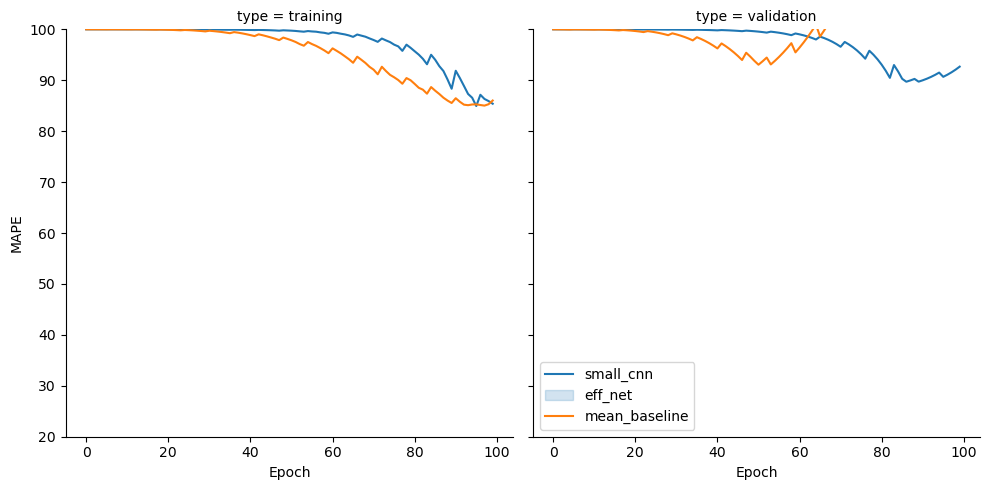

In [108]:
model_history_small_cnn = history_basic
model_history_eff_net = history_pretrain
mean_baseline = mape

# create a dictionary for each model history and loss type
dict1 = {
    "MAPE": model_history_small_cnn.history["mean_absolute_percentage_error"],
    "type": "training",
    "model": "small_cnn",
}
dict2 = {
    "MAPE": model_history_small_cnn.history["val_mean_absolute_percentage_error"],
    "type": "validation",
    "model": "small_cnn",
}
dict3 = {
    "MAPE": model_history_eff_net.history["mean_absolute_percentage_error"],
    "type": "training",
    "model": "eff_net",
}
dict4 = {
    "MAPE": model_history_eff_net.history["val_mean_absolute_percentage_error"],
    "type": "validation",
    "model": "eff_net",
}

# convert the dicts to pd.Series and concat them to a pd.DataFrame in the long format
s1 = pd.DataFrame(dict1)
s2 = pd.DataFrame(dict2)
s3 = pd.DataFrame(dict3)
s4 = pd.DataFrame(dict4)
result_df = pd.concat([s1, s2, s3, s4], axis=0).reset_index()

# Create Plot
grid = sns.relplot(data=result_df, x=result_df["index"], y="MAPE", hue="model", col="type", kind="line", legend=False)
grid.set(ylim=(20, 100))  # set the y-axis limit

for ax in grid.axes.flat:
    ax.axhline(
        y=mean_baseline, color="lightcoral", linestyle="dashed"
    )  # add a mean baseline horizontal bar to each plot
    ax.set(xlabel="Epoch")

labels = ["small_cnn", "eff_net", "mean_baseline"]  # custom labels for the plot

plt.legend(labels=labels)
plt.savefig("training_validation.png")
plt.show()

# Visulize results

In [129]:
# Get Predictions from models

pretrained_pred = model_pretrain.predict(test_generator).flatten()
basic_pred = model_basic.predict(test_generator).flatten()

1/1 [==============================] - 0s 190ms/step


Data Type: float32
Batch Data Shape: (8, 224, 224, 3)


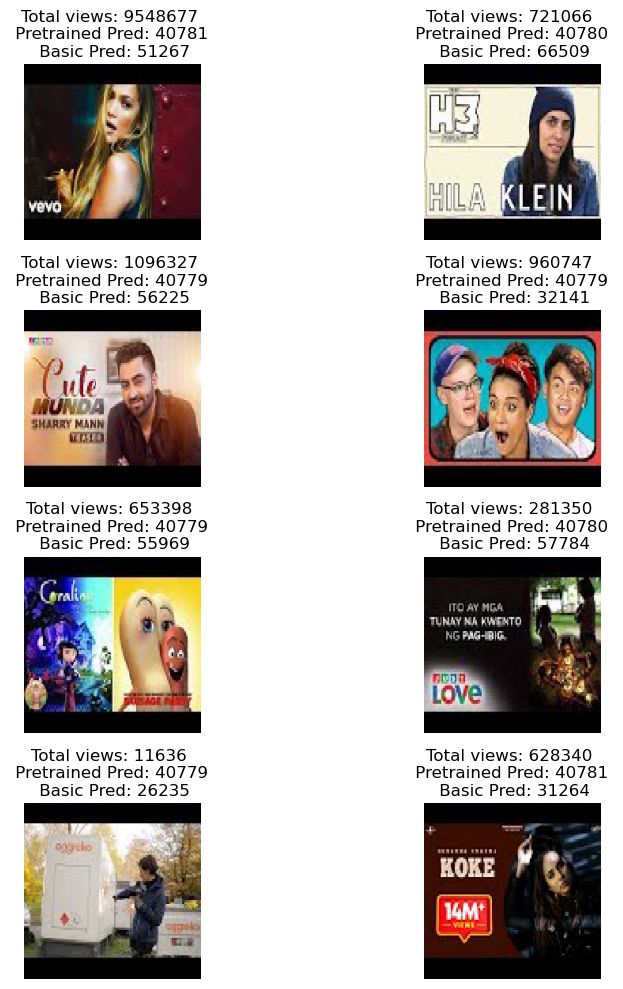

In [134]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming you have an ImageDataGenerator called 'data_generator' set up

# Generate a batch of data with labels from the generator
batch_data, batch_labels = next(test_generator)

# Check the shape of the batch data
print("Data Type:", batch_data.dtype)
print("Batch Data Shape:", batch_data.shape)

# Plot the images in the data batch with labels
num_images = len(batch_data)
num_rows = num_images // 2 + num_images % 2  # Calculate the number of rows

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(10, 10))

for i, (image, label) in enumerate(zip(batch_data, batch_labels)):
    row = i // 2  # Calculate the row index
    col = i % 2   # Calculate the column index

    axes[row, col].imshow(image)
    axes[row, col].axis('off')
    axes[row, col].set_title(f"Total views: {label} \n Pretrained Pred: {int(pretrained_pred[i])} \n Basic Pred: {int(basic_pred[i])}")  # Display the label

# If the number of images is odd, remove the empty subplot
if num_images % 2 != 0:
    fig.delaxes(axes[num_rows-1, 1])

plt.tight_layout()
plt.show()
